In [231]:
import boto3
import chart_studio.plotly as py
import cufflinks as cf
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as ex
import seaborn as sb

from botocore.exceptions import ClientError
from collections import Counter
from io import StringIO
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
from textblob import TextBlob
from warnings import filterwarnings

In [232]:
def get_secret():
    secret_name = "s3_data_analysis"
    region_name = "us-east-1"

    # Create a Secrets Manager client with default credentials
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        # Retrieve the secret value from Secrets Manager
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    # Extract the secret string (which is a JSON object)
    secret = get_secret_value_response['SecretString']
    
    # Parse the secret string as JSON
    secrets = json.loads(secret)
    
    # Retrieve AWS credentials from the secrets
    aws_access_key_id = secrets['aws_access_key_id']
    aws_secret_access_key = secrets['aws_secret_access_key']
    
    # Now use the retrieved credentials to create the S3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )

    return s3_client

s3_client = get_secret()

In [233]:
bucket_name = 'nk.data.analysis'
path = 'COVID_Analysis/covid_analysis'

In [234]:
files = [
    file["Key"].removeprefix("COVID_Analysis/covid_analysis/") for file in s3_client.list_objects_v2(Bucket=bucket_name, Prefix="COVID_Analysis/").get("Contents", [])
    if not file["Key"].endswith("/")
]

In [235]:
def read_csv_from_s3(bucket_name, key, s3_client):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        data = StringIO(csv_content)
        df = pd.read_csv(data)
        return df
    except Exception as e:
         print(f"Error reading CSV from S3: {e}")
         return None

In [236]:
for file in files:
    var_name = file.replace('.csv', '').replace('-', '_')  # Ensure valid variable names
    globals()[var_name] = read_csv_from_s3(bucket_name, path + '/' + file, s3_client)

worldometer_data.head()

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,Americas
1,Brazil,South America,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,Americas
2,India,Asia,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,South-EastAsia
3,Russia,Europe,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,Europe
4,South Africa,Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,Africa


In [237]:
columns = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases']
for col in columns:
    fig = ex.treemap(worldometer_data.iloc[0:20], values = col, path = ['Country/Region'], title = 'Treemap representation of countries wrt {}'.format(col))
    fig.show()

In [238]:
ex.line(day_wise, x='Date', y=['Confirmed', 'Deaths', 'Recovered', 'Active'], title='COVID wrt Date', template='plotly_dark')

In [239]:
pop_test_ratio = worldometer_data['Population']/worldometer_data['TotalTests'].iloc[0:20]

In [240]:
fig = ex.bar(worldometer_data.iloc[0:20],x='Country/Region',y=pop_test_ratio.iloc[0:20],color='Country/Region',title='Population to tests done ratio')
fig.show()

In [241]:
ex.bar(worldometer_data.iloc[0:20],x='Country/Region',y=['Serious,Critical', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'TotalCases'])

In [242]:
fig = ex.bar(worldometer_data.iloc[0:20],x='TotalCases',y='Country/Region',text='TotalCases', color='TotalCases')
fig.update_layout(template='plotly_dark', title_text='Top 20 countries of confirmed COVID cases')
fig.show()

In [243]:
fig = ex.bar(worldometer_data.sort_values(by='TotalDeaths', ascending=False)[0:20],x='TotalDeaths',y='Country/Region',text='TotalDeaths', color='TotalDeaths')
fig.update_layout(template='plotly_dark', title_text='Top 20 countries of total death COVID cases')
fig.show()

In [244]:
fig = ex.bar(worldometer_data.sort_values(by='ActiveCases', ascending=False)[0:20],x='ActiveCases',y='Country/Region',text='ActiveCases', color='ActiveCases')
fig.update_layout(template='plotly_dark', title_text='Top 20 countries of total active COVID cases')
fig.show()

In [245]:
fig = ex.bar(worldometer_data.sort_values(by='TotalRecovered', ascending=False)[0:20],x='TotalRecovered',y='Country/Region',text='TotalRecovered', color='TotalRecovered')
fig.update_layout(template='plotly_dark', title_text='Top 20 countries of total recovered COVID cases')
fig.show()

In [246]:
labels = worldometer_data[0:15]['Country/Region'].values
cases = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases']
for case in cases:
    fig = ex.pie(worldometer_data[0:15],values=case,names=labels,hole=0.3,title='{} worst 15 affected countries'.format(case))
    fig.show()

In [247]:
deaths_to_confirmed_cases = worldometer_data['TotalDeaths']/worldometer_data['TotalCases']

In [248]:
ex.bar(worldometer_data,x='Country/Region',y=deaths_to_confirmed_cases,title='Death to Confirmed Cases/Worst Country')

In [249]:
deaths_to_recovered_cases = worldometer_data['TotalDeaths']/worldometer_data['TotalRecovered']
ex.bar(worldometer_data,x='Country/Region',y=deaths_to_recovered_cases,title='Death to Recovered Cases/Worst Country')

In [250]:
tests_to_confirmed_cases = worldometer_data['TotalTests']/worldometer_data['TotalCases']
ex.bar(worldometer_data,x='Country/Region',y=tests_to_confirmed_cases,title='Tests to Confirmed Cases/Worst Country')

In [251]:
serious_to_death_cases = worldometer_data['Serious,Critical']/worldometer_data['TotalDeaths']
ex.bar(worldometer_data,x='Country/Region',y=serious_to_death_cases,title='Serious/Critical to Deaths/Worst Country')

In [252]:
def country_visualization(df,country):
    
    data=df[df['Country/Region']==country]
    
    df=data.loc[:,['Date','Confirmed','Deaths','Recovered','Active']]
    
    fig = make_subplots(rows=1, cols=4,subplot_titles=("Confirmed", "Active", "Recovered",'Deaths'))
    
    fig.add_trace(
        go.Scatter(name="Confirmed",x=df['Date'],y=df['Confirmed']),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(name="Active",x=df['Date'],y=df['Active']),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(name="Recovered",x=df['Date'],y=df['Recovered']),
        row=1, col=3
    )

    fig.add_trace(
        go.Scatter(name="Deaths",x=df['Date'],y=df['Deaths']),
        row=1, col=4
    )

    fig.update_layout(height=600, width=1000, title_text="Date Vs Recorded Cases of {}".format(country),template="plotly_dark")
    fig.show()

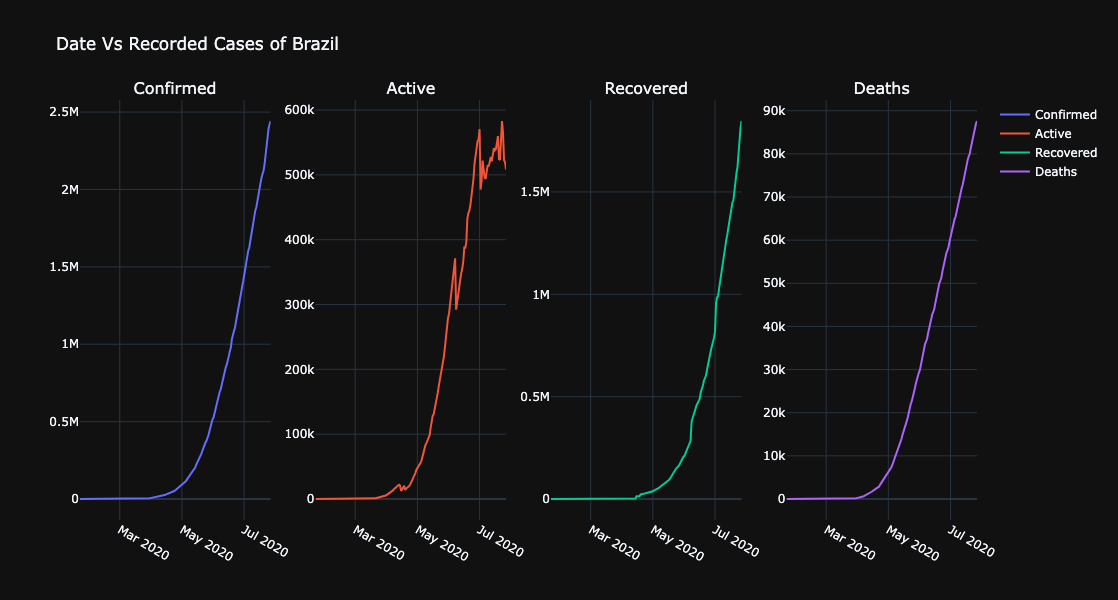

In [253]:
country_visualization(full_grouped,'Brazil')

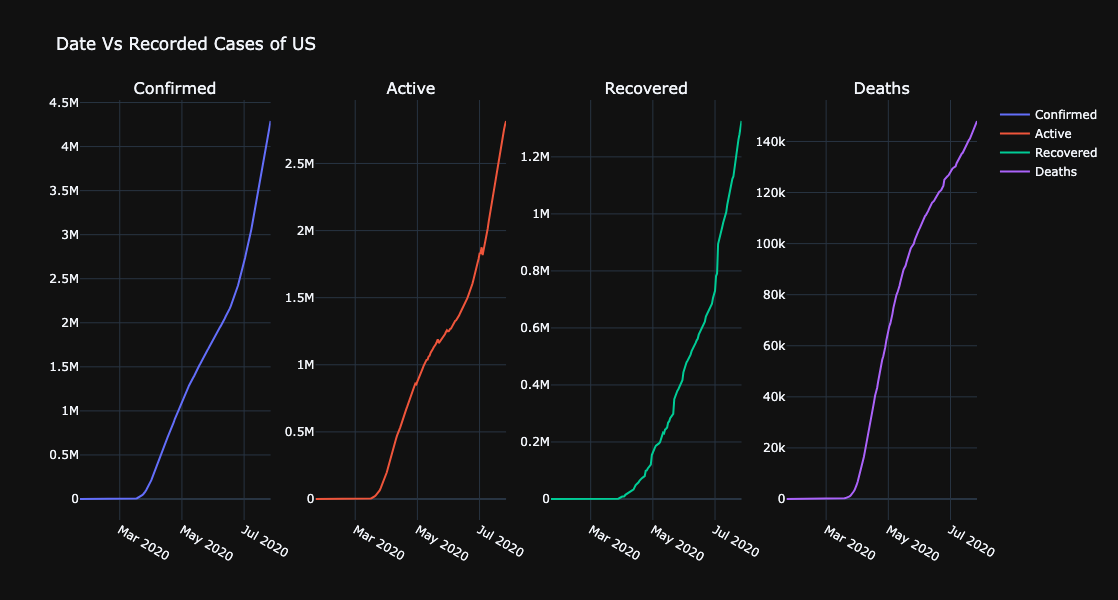

In [254]:
country_visualization(full_grouped,'US')